<h1 style='color:Green' align='center'>Celebrity Image Classification<h1>


In [71]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h2>Preprocessing :- Detect face and eyes</h2>


In [72]:
img = cv2.imread('./test_images/linus1.jpg')
img.shape

(225, 225, 3)

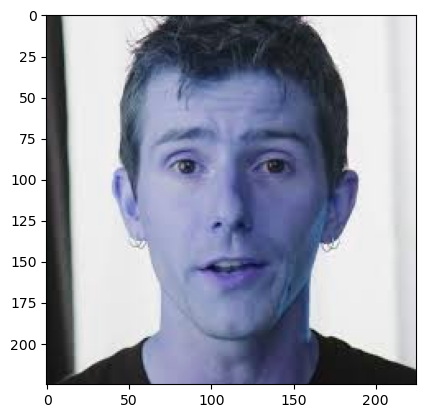

In [73]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(225, 225)

In [5]:
gray #representation in terms of matrix

array([[ 49,  48,  47, ..., 238, 238, 238],
       [ 49,  48,  47, ..., 238, 238, 238],
       [ 49,  48,  47, ..., 238, 238, 238],
       ...,
       [ 24,  23,  20, ...,  25,  25,  23],
       [ 24,  23,  20, ...,  24,  24,  22],
       [ 19,  22,  23, ...,  24,  23,  25]], dtype=uint8)

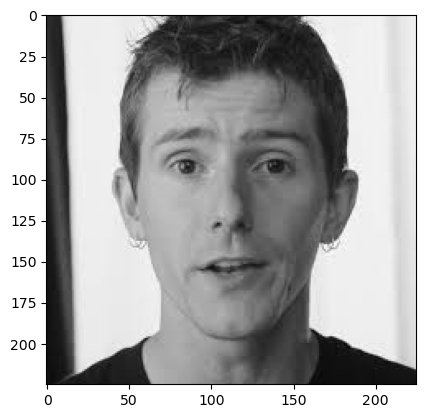

In [6]:
plt.imshow(gray, cmap='gray')

Using HaarCascade(Refer to OpenCV Documentation)


In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 39,  32, 149, 149]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(39, 32, 149, 149)

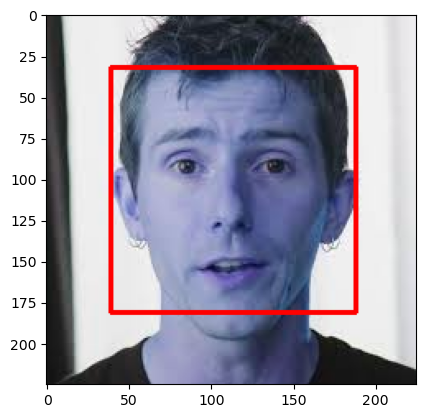

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

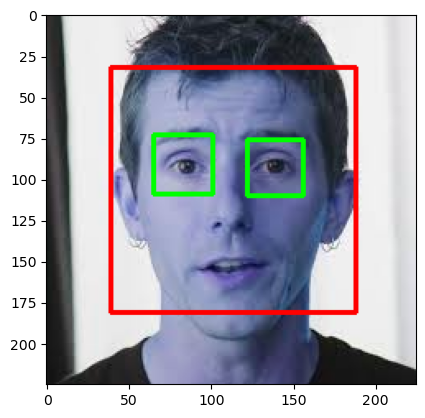

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

Crop The Face


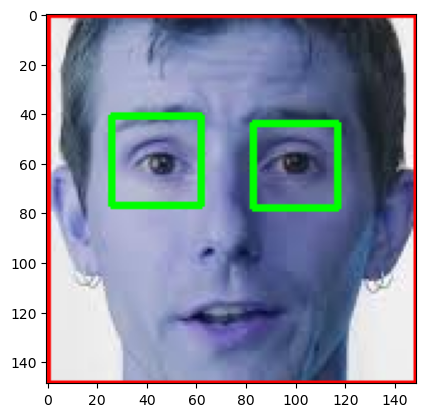

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(149, 149, 3)

Preprocessing: Use wavelet transform as a feature for traning our model


Wavelet Transformation (Help model distinguish between eyes, nose, ear, etc)


### Wavelet Transformation (Stackoverflow)


In [13]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

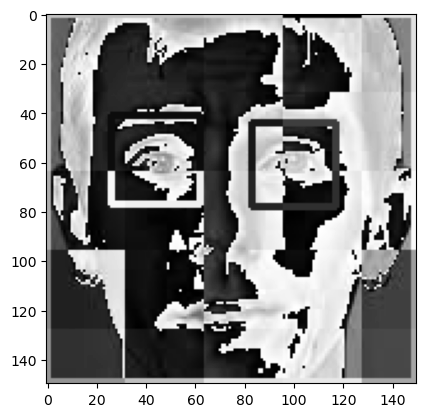

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region


Function to get a image and crop it if it has 2 eyes. We are converting it to grayscale to reduce a RGB dimension(Which makes things way easier)


In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image not found or unable to read: {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            roi_color = img[y:y+h, x:x+w]
            return roi_color
    return None

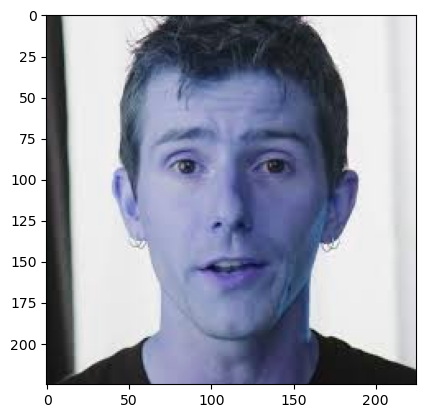

In [16]:
original_image = cv2.imread('./test_images/linus1.jpg')
plt.imshow(original_image)

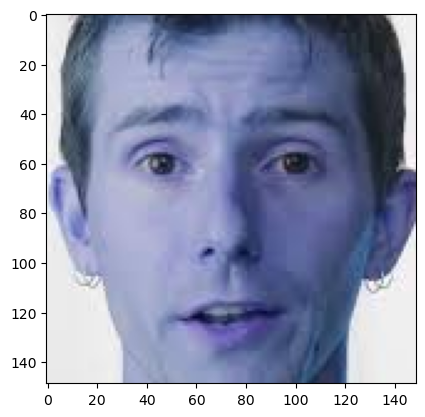

In [17]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/linus1.jpg')
plt.imshow(cropped_image)

**In the below image face is not very clear and it doesn't have two eyes clearly visible**


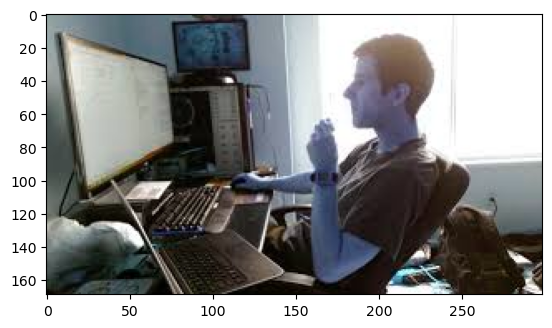

In [18]:
org_image_obstructed = cv2.imread('./test_images/linus2.jpeg')
plt.imshow(org_image_obstructed)

In [19]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/linus2.jpeg')
cropped_image_no_2_eyes

This image doesn't have visible eyes so we won't use these images for training as of now


In [42]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [43]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [44]:
img_dirs

['./dataset/elon_musk',
 './dataset/harshita_gaur',
 './dataset/amber_heard',
 './dataset/linus_sebastian',
 './dataset/cropped']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after executing this code**


In [45]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [46]:

cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        print(f"Processing file: {entry.path}")
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

print("Cropped image directories:", cropped_image_dirs)
print("Celebrity file names dict:", celebrity_file_names_dict)

Processing file: ./dataset/elon_musk/image_193.jpg
Processing file: ./dataset/elon_musk/image_178.jpg
Generating cropped images in folder:  ./dataset/cropped/elon_musk
Processing file: ./dataset/elon_musk/image_144.jpg
Processing file: ./dataset/elon_musk/image_352.jpg
Processing file: ./dataset/elon_musk/image_346.jpg
Processing file: ./dataset/elon_musk/image_72.jpeg
Processing file: ./dataset/elon_musk/image_25.jpeg
Processing file: ./dataset/elon_musk/image_233.jpg
Processing file: ./dataset/elon_musk/image_227.jpg
Processing file: ./dataset/elon_musk/image_390.jpg
Processing file: ./dataset/elon_musk/image_151.jpg
Processing file: ./dataset/elon_musk/image_179.jpg
Processing file: ./dataset/elon_musk/image_186.jpg
Processing file: ./dataset/elon_musk/image_192.jpg
Processing file: ./dataset/elon_musk/image_48.jpeg
Processing file: ./dataset/elon_musk/image_190.jpg
Processing file: ./dataset/elon_musk/image_153.jpg
Processing file: ./dataset/elon_musk/image_392.jpg
Processing file:

### Manually examine cropped folder and delete any unwanted images (EVERYONE DOES THIS)}


In [47]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'elon_musk': ['./dataset/cropped/elon_musk/elon_musk19.png',
  './dataset/cropped/elon_musk/elon_musk31.png',
  './dataset/cropped/elon_musk/elon_musk25.png',
  './dataset/cropped/elon_musk/elon_musk24.png',
  './dataset/cropped/elon_musk/elon_musk30.png',
  './dataset/cropped/elon_musk/elon_musk18.png',
  './dataset/cropped/elon_musk/elon_musk26.png',
  './dataset/cropped/elon_musk/elon_musk32.png',
  './dataset/cropped/elon_musk/elon_musk33.png',
  './dataset/cropped/elon_musk/elon_musk27.png',
  './dataset/cropped/elon_musk/elon_musk23.png',
  './dataset/cropped/elon_musk/.DS_Store',
  './dataset/cropped/elon_musk/elon_musk36.png',
  './dataset/cropped/elon_musk/elon_musk22.png',
  './dataset/cropped/elon_musk/elon_musk34.png',
  './dataset/cropped/elon_musk/elon_musk20.png',
  './dataset/cropped/elon_musk/elon_musk21.png',
  './dataset/cropped/elon_musk/elon_musk35.png',
  './dataset/cropped/elon_musk/elon_musk46.png',
  './dataset/cropped/elon_musk/elon_musk1.png',
  './dataset/c

In [48]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'elon_musk': 0, 'harshita_gaur': 1, 'amber_heard': 2, 'linus_sebastian': 3}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now


In [49]:
import cv2
import numpy as np

X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        try:
            img = cv2.imread(training_image)
            if img is None:
                raise ValueError(f"Image at {training_image} could not be loaded.")
                
            scalled_raw_img = cv2.resize(img, (32, 32))
            img_har = w2d(img, 'db1', 5)
            scalled_img_har = cv2.resize(img_har, (32, 32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)))
            X.append(combined_img)
            y.append(class_dict[celebrity_name])
        except Exception as e:
            print(f"Skipping image {training_image} due to error: {e}")
            continue

Skipping image ./dataset/cropped/elon_musk/.DS_Store due to error: Image at ./dataset/cropped/elon_musk/.DS_Store could not be loaded.
Skipping image ./dataset/cropped/harshita_gaur/.DS_Store due to error: Image at ./dataset/cropped/harshita_gaur/.DS_Store could not be loaded.
Skipping image ./dataset/cropped/amber_heard/.DS_Store due to error: Image at ./dataset/cropped/amber_heard/.DS_Store could not be loaded.
Skipping image ./dataset/cropped/linus_sebastian/.DS_Store due to error: Image at ./dataset/cropped/linus_sebastian/.DS_Store could not be loaded.


In [50]:
len(X[0])

4096

In [51]:
32*32*3 + 32*32

4096

In [52]:
X[0]

array([[27],
       [48],
       [70],
       ...,
       [ 0],
       [ 0],
       [ 0]], dtype=uint8)

In [53]:
y[0]

0

In [54]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(201, 4096)

### Data cleaning process is done. Now we are ready to train our model


We will use SVM with rbf kernel tuned with heuristic finetuning


In [55]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8431372549019608

In [57]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       1.00      1.00      1.00        11
           2       0.83      0.83      0.83        12
           3       0.82      0.82      0.82        17

    accuracy                           0.84        51
   macro avg       0.85      0.85      0.85        51
weighted avg       0.84      0.84      0.84        51



GridSearch to minimize error


In [58]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [59]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [60]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.853333,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.646667,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.840000,{'logisticregression__C': 1}


In [61]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [62]:
best_estimators['svm'].score(X_test,y_test)

0.8431372549019608

In [63]:
best_estimators['random_forest'].score(X_test,y_test)

0.6470588235294118

In [64]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8627450980392157

In [65]:
best_clf = best_estimators['svm']

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 8,  0,  2,  1],
       [ 0, 11,  0,  0],
       [ 0,  0, 10,  2],
       [ 3,  0,  0, 14]])

Text(95.72222222222221, 0.5, 'Truth')

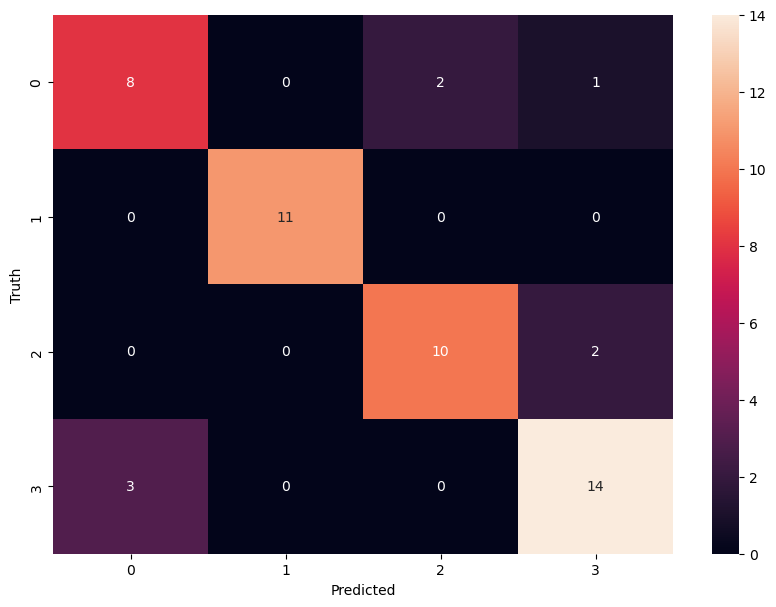

In [67]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [68]:
class_dict

{'elon_musk': 0, 'harshita_gaur': 1, 'amber_heard': 2, 'linus_sebastian': 3}

### Save the trained model


In [69]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary


In [70]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))